Load Tensorflow

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import random
import os
from PIL import Image

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import utils
from tensorflow.keras import Model



TensorFlow version: 2.4.3


Load helper functions and preview the data

In [2]:
from src.datareader import get_metadata, get_summary_data
from src.find_images_without_metadata import find_images_without_metadata

In [3]:
metadata: pd.DataFrame = get_metadata()
summarydata: pd.DataFrame = get_summary_data()
print(summarydata)

      Label Label_2_Virus_category Label_1_Virus_category  Image_Count
0    Normal                                                       1576
1  Pnemonia         Stress-Smoking                   ARDS            2
2  Pnemonia                  Virus                                1493
3  Pnemonia                  Virus               COVID-19           58
4  Pnemonia                  Virus                   SARS            4
5  Pnemonia               bacteria                                2772
6  Pnemonia               bacteria          Streptococcus            5


In [4]:
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,,
1,IM-0127-0001.jpeg,Normal,TRAIN,,
2,IM-0125-0001.jpeg,Normal,TRAIN,,
3,IM-0122-0001.jpeg,Normal,TRAIN,,
4,IM-0119-0001.jpeg,Normal,TRAIN,,


Let's verify that all the images are in the metadata, else we could run into issues if not careful. If you run into any problems, stop here and fix them.

In [5]:
for dataset in ['TRAIN', 'TEST']:
    find_images_without_metadata(dataset)


Both lists match for the TRAIN dataset
Both lists match for the TEST dataset


Separate between training and testing

In [6]:
train_sample = metadata.loc[metadata['Dataset_type'] == 'TRAIN']
test_sample = metadata.loc[metadata['Dataset_type'] == 'TEST']

Preview some images in the training data

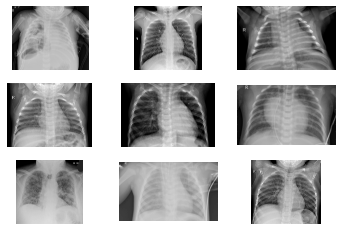

In [7]:
fig, axes = plt.subplots(3, 3, squeeze=False, )
random_image_indices = random.sample(range(len(train_sample)), 9)
image_names = list(train_sample.iloc[random_image_indices]['X_ray_image_name'])
for n in range(9):
    this_axis = axes[n//3, n%3]
    filename = os.path.join(os.getcwd(), 'dataset', 'TRAIN', image_names[n])
    img = mpimg.imread(filename)
    imgplot = this_axis.imshow(img, cmap='gray')
    this_axis.axis('off')


As you can see, the images are not uniform in shape, so we still have some preprocessing to do

In [8]:
image_size_counter = {}
for basename in train_sample['X_ray_image_name']:
    filename = os.path.join(os.getcwd(), 'dataset', 'TRAIN', basename)
    size = Image.open(filename).size
    if size in image_size_counter.keys():
        image_size_counter[(size, size[0] * size[1])] += 1
    else:
        image_size_counter[(size, size[0] * size[1])] = 1
smallest_picture_index = np.argmin([x[1] for x in list(image_size_counter.keys())])
largest_picture_index = np.argmax([x[1] for x in list(image_size_counter.keys())])
print('Smallest image size: ', list(image_size_counter.keys())[smallest_picture_index][0])
print('Large image size: ', list(image_size_counter.keys())[largest_picture_index][0])

Smallest image size:  (384, 127)
Large image size:  (4248, 3480)


Since the images differ widely in size, we must resort to resizing them.
The method employed here is to downsample and low-pass filter

In [9]:
new_size = (256, 256)
